### Импорт библиотек

In [1]:
from IPython.display import Image, Latex, Math
from numpy import pi
from qutip import *
from pylab import *
import pandas as pd
%matplotlib inline

### Изучаем разные метрики качества работы кубитов. В этом примере мы будем искать меру декогеренции, равную точной верхней грани (по начальным состояниям первого кубита) операторной нормы разностей начальной и конечной матриц плотности первого кубита. Нас интересует состояние первого кубита (на рисунке сверху). Второй кубит иллюстрирует окружение, алгоритм - процесс запутывания с окружением. Начальное состояние второго кубита - | 0 >, первого - произвольное чистое.

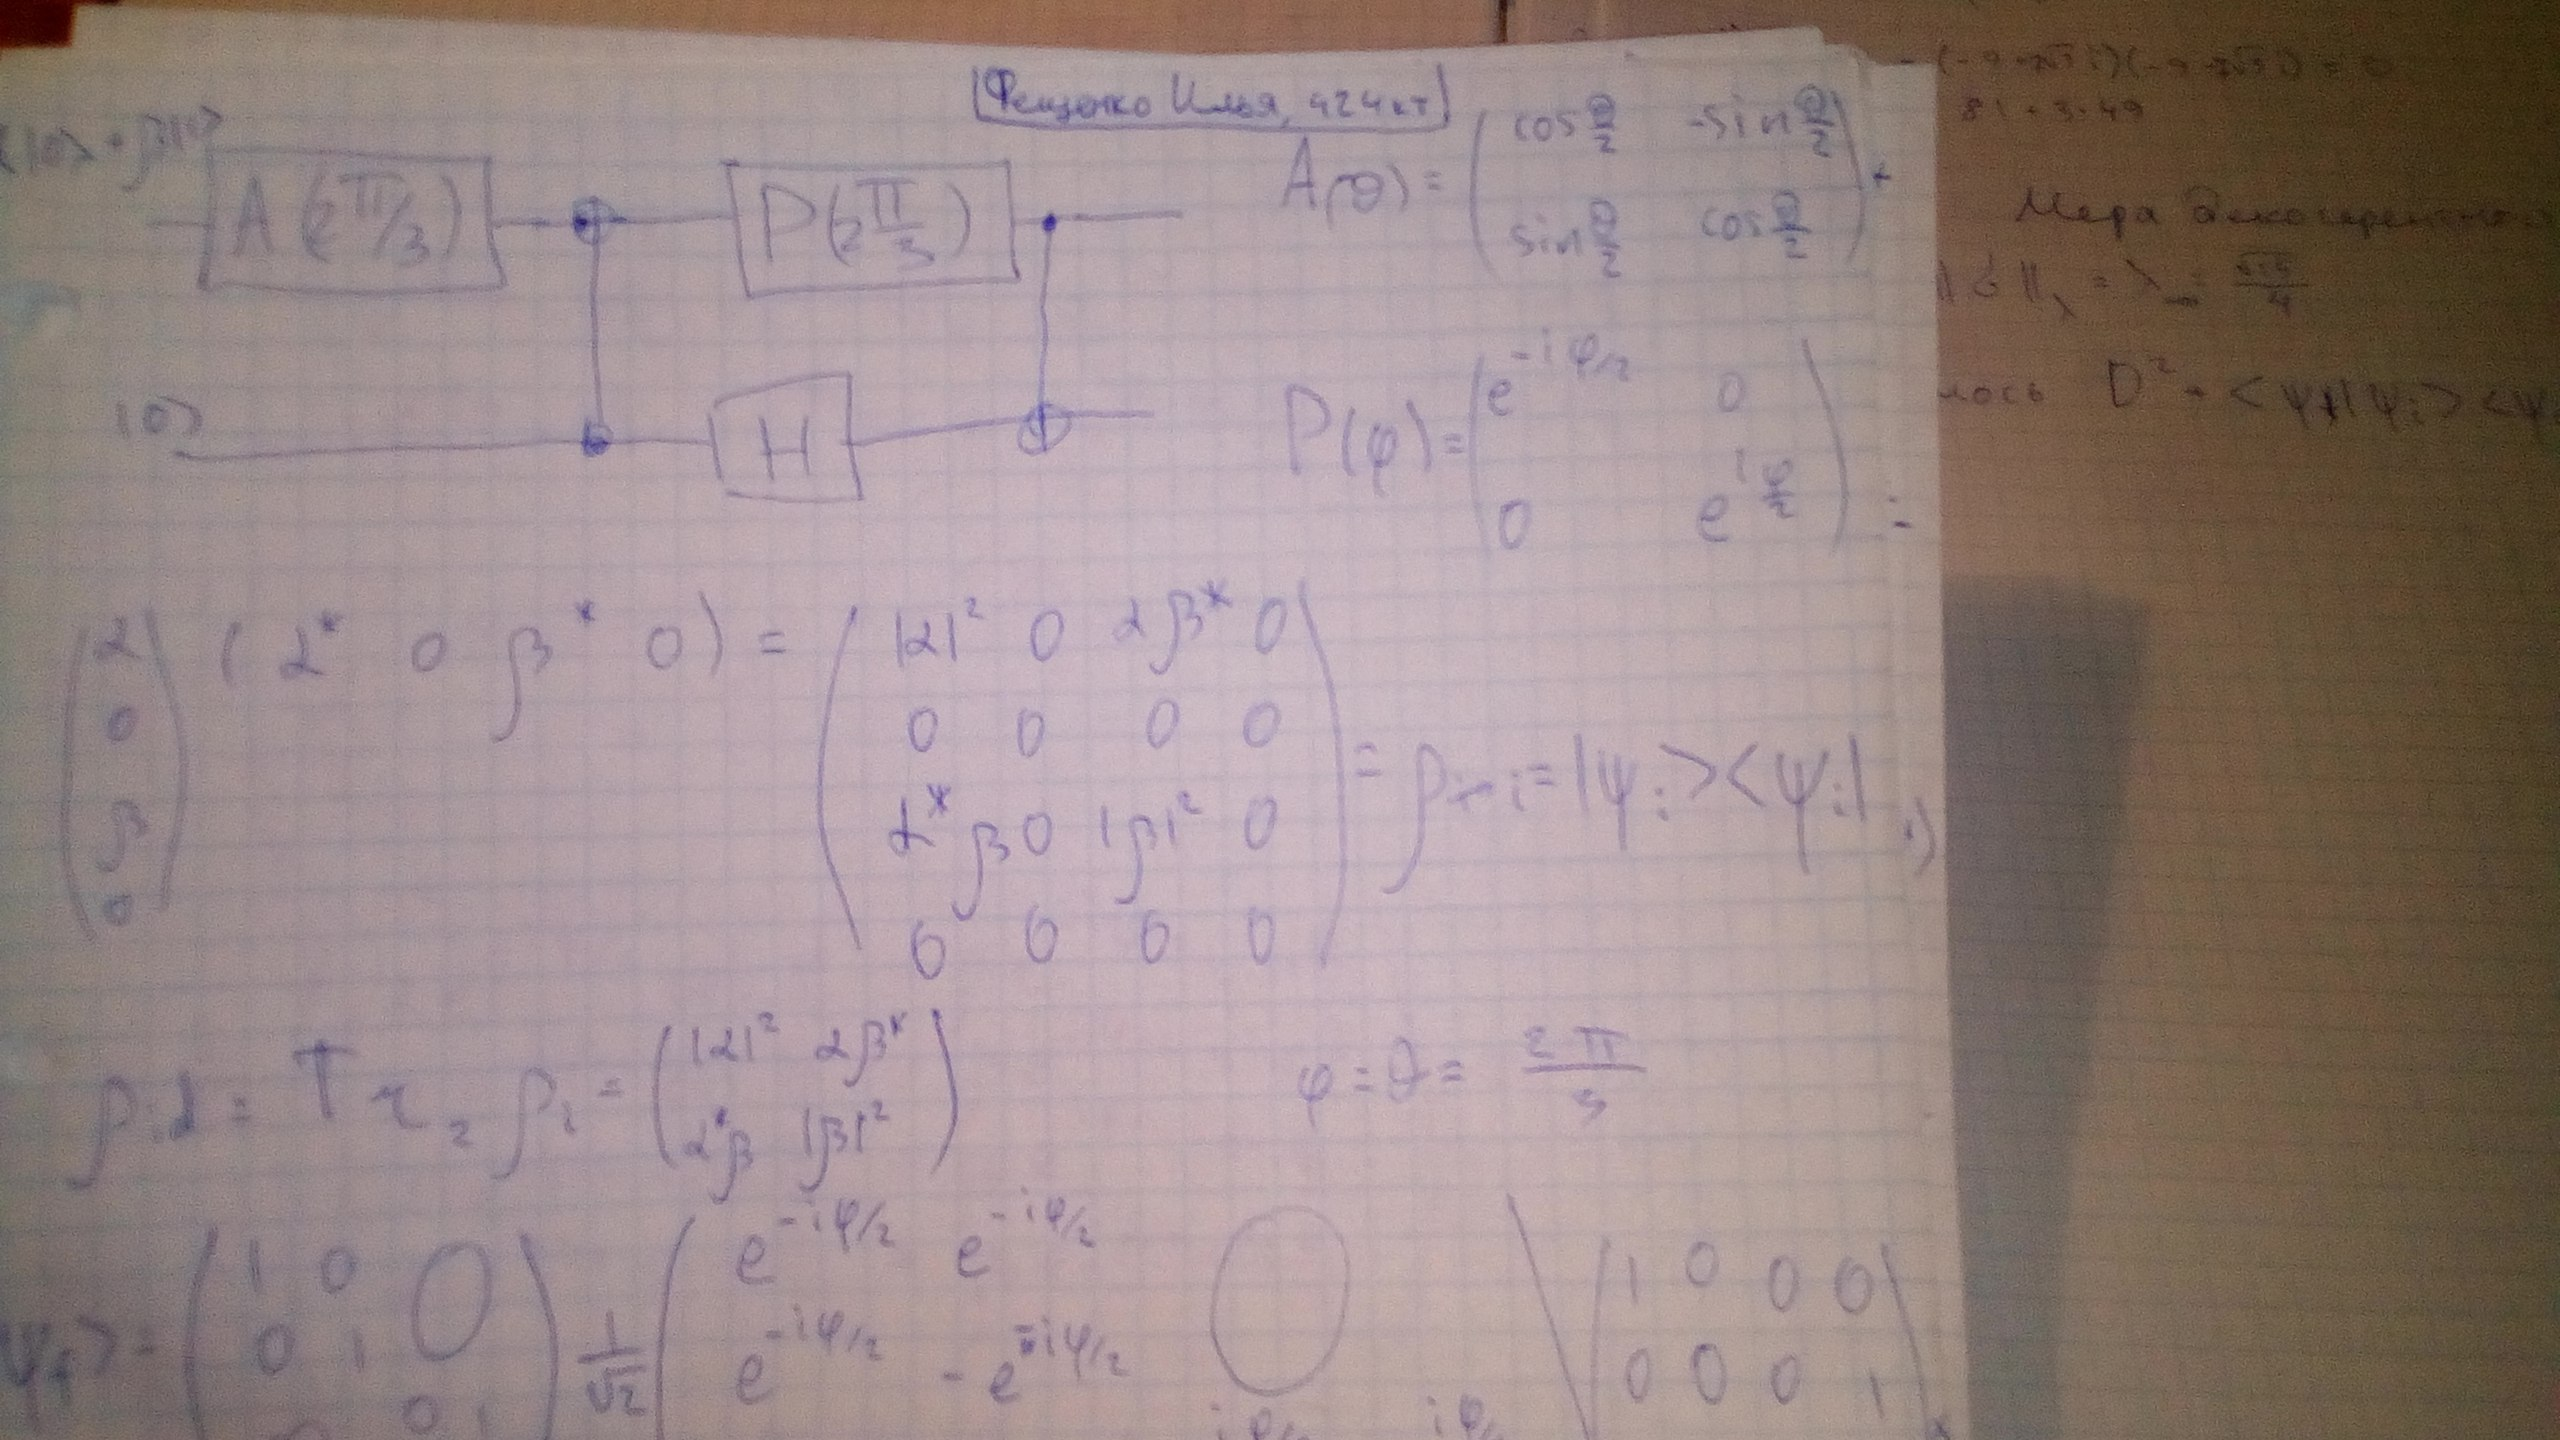

In [2]:
Image(filename='Algorithm.jpg')

### Тут немного по-другому называются нужные нам гейты:

#### A: RY (Амплитудное вращение)

In [3]:
ry(2*pi/3)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.5       -0.8660254]
 [ 0.8660254  0.5      ]]

#### P: RZ (Фазовое вращение)

In [4]:
rz(2*pi/3)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.5-0.8660254j  0.0+0.j       ]
 [ 0.0+0.j         0.5+0.8660254j]]

#### H: SNOT (Вентиль Адамара)

In [5]:
snot()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

### Инициализация и редактирование цепи с количеством кубитов, равным 2

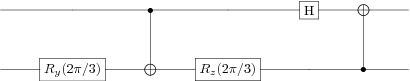

In [6]:
qc2 = QubitCircuit(2)
qc2.add_gate("RY", 0, arg_value=2*pi/3, arg_label=r"2\pi/3")
qc2.add_gate("CNOT", 0, 1)
qc2.add_gate("RZ", 0, arg_value=2*pi/3, arg_label=r"2\pi/3")
qc2.add_gate("SNOT", 1)
qc2.add_gate("CNOT", 1, 0)
qc2.png

### Сравниваем с тем, что нам было нужно.

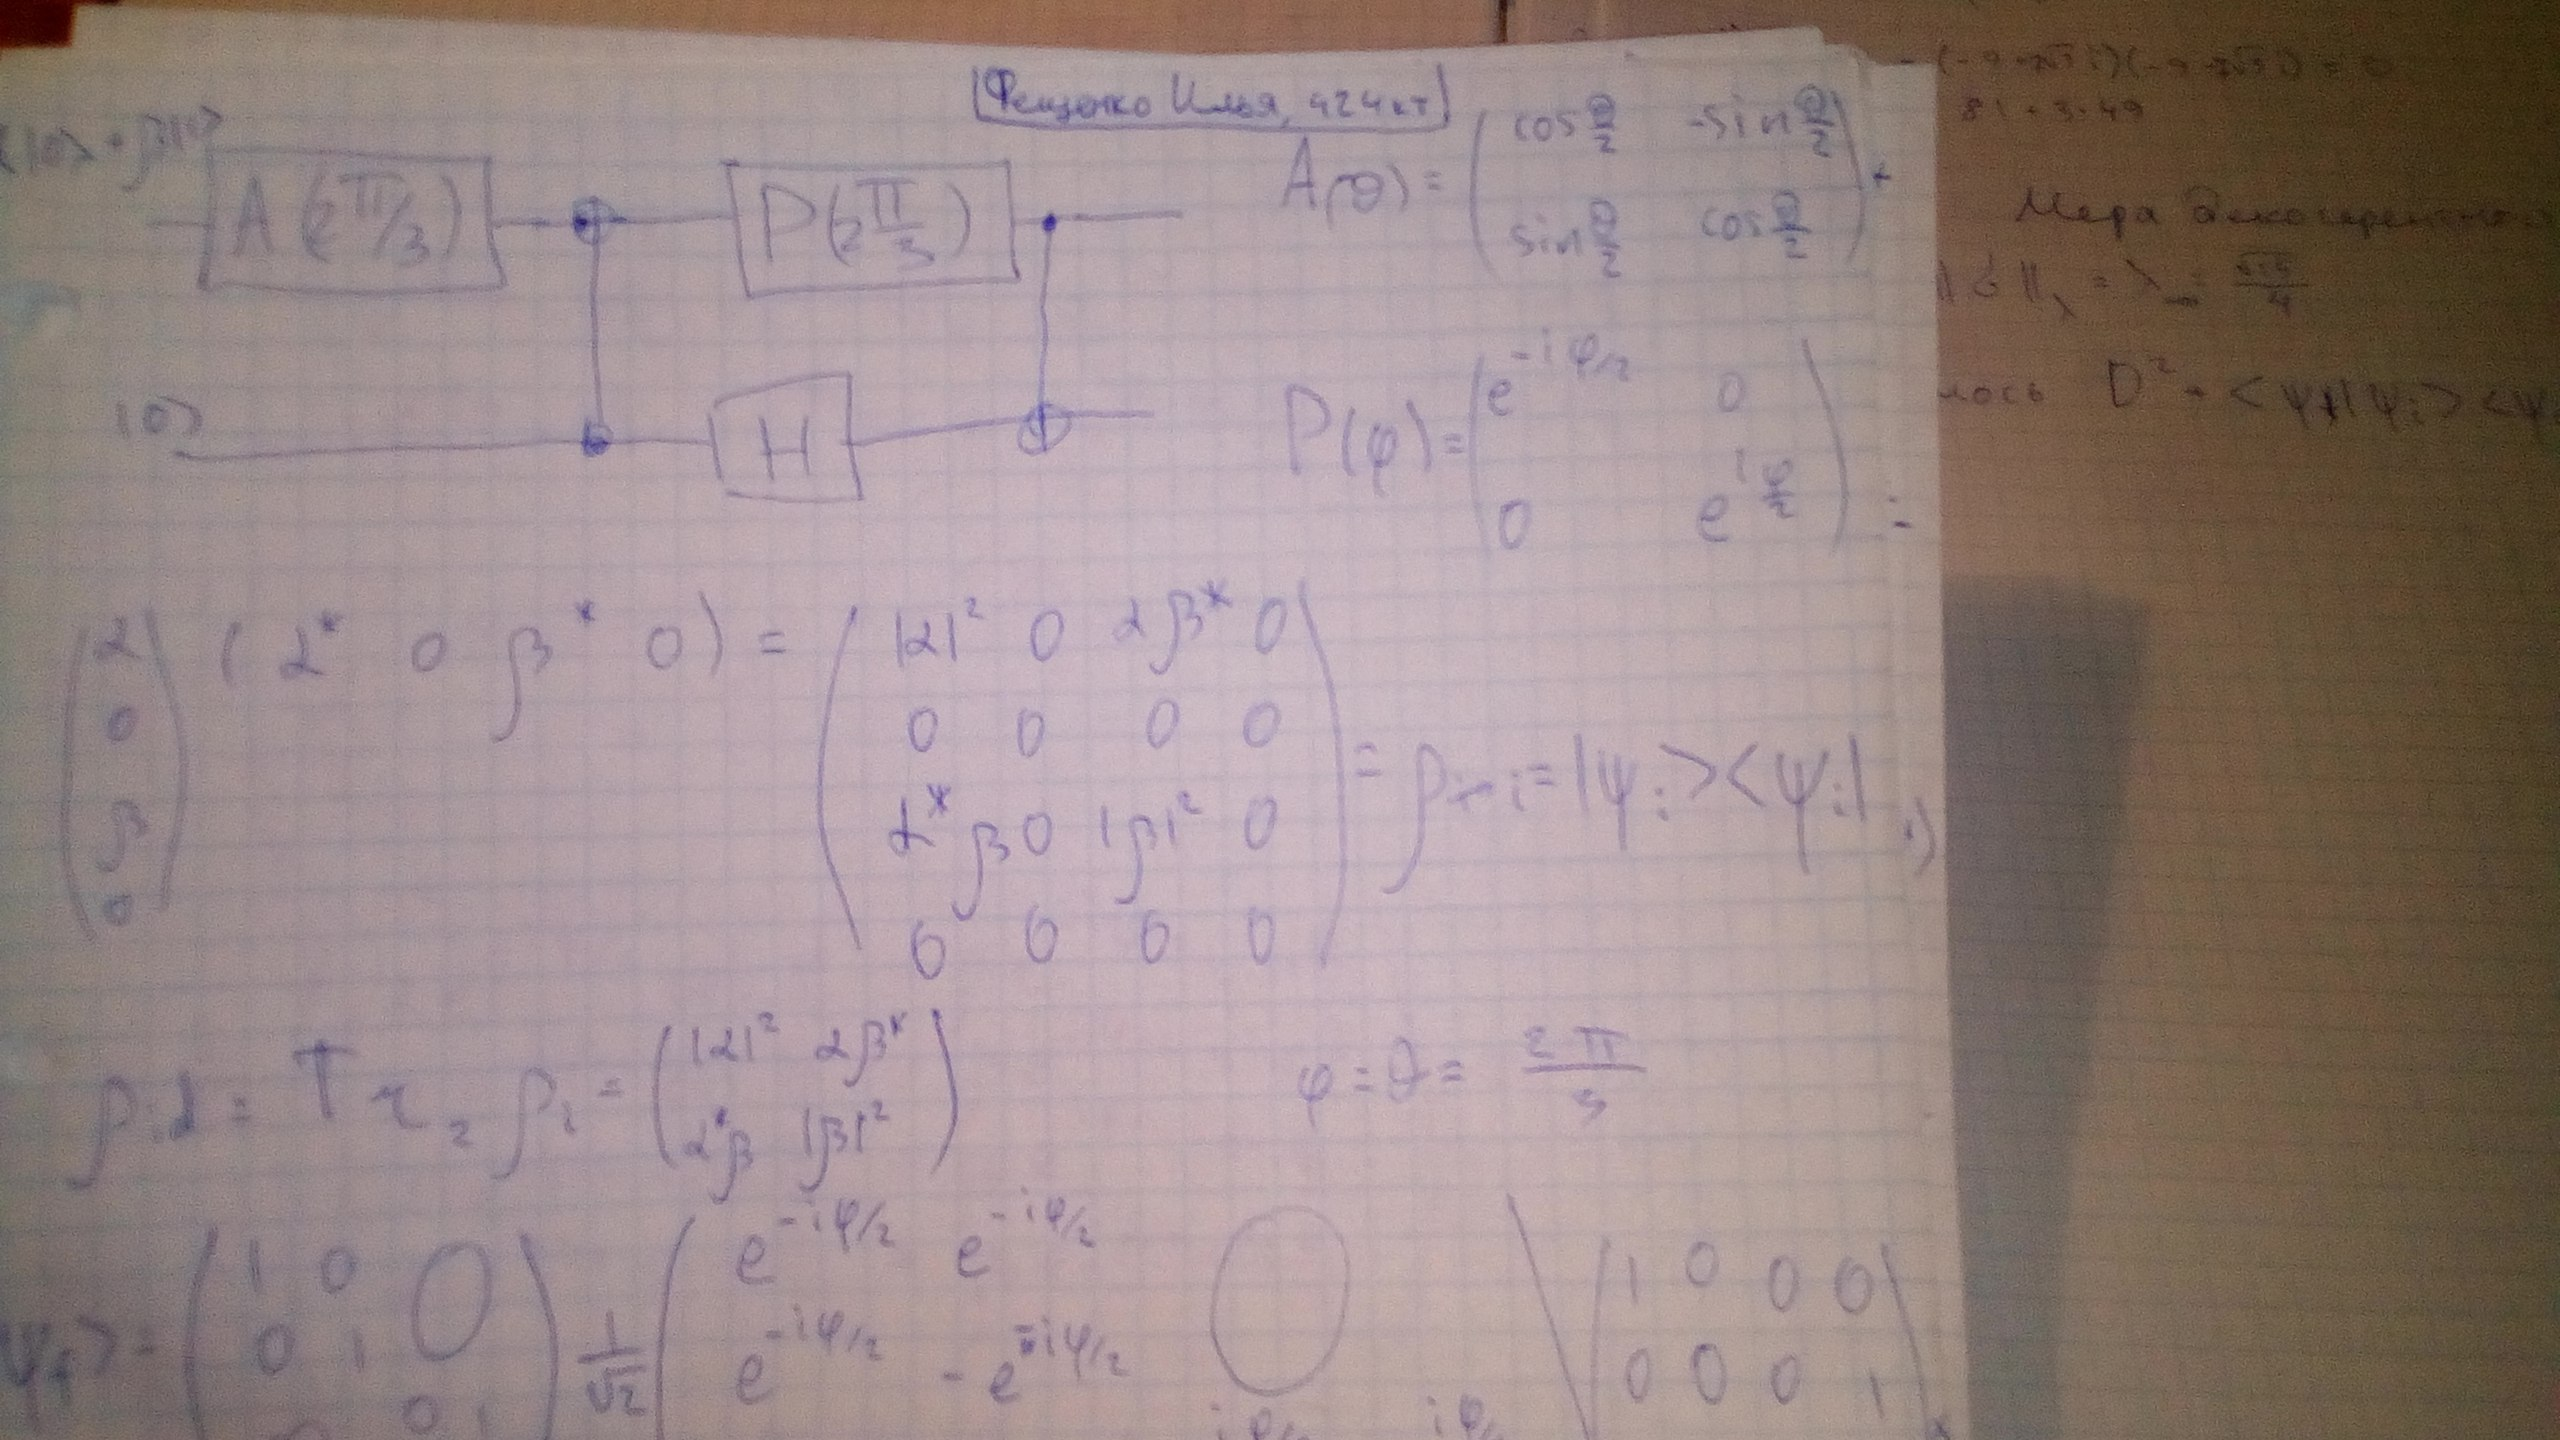

In [7]:
Image(filename='Algorithm.jpg')

#### Изображение перевёрнуто, а так всё верно

### Матрица двухкубитного преобразования

In [8]:
gsp = gate_sequence_product(qc2.propagators())
gsp

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.17677670-0.30618622j  0.30618622-0.53033009j -0.30618622+0.53033009j
   0.17677670-0.30618622j]
 [ 0.17677670-0.30618622j -0.30618622+0.53033009j -0.30618622+0.53033009j
  -0.17677670+0.30618622j]
 [ 0.30618622+0.53033009j -0.17677670-0.30618622j  0.17677670+0.30618622j
   0.30618622+0.53033009j]
 [ 0.30618622+0.53033009j  0.17677670+0.30618622j  0.17677670+0.30618622j
  -0.30618622-0.53033009j]]

### Можно заметить, что конечное состояние по-прежнему сепарабельно, поскольку второй кубит перед началом алгоритма в состоянии | 0 >, так что интересны нам только первый и третий столбцы (с индексами 0 и 2, соответствующие состояниям системы | 0, 0 > и | 1, 0 >). Покажем это:

In [9]:
Final_state_for_initial_00 = gsp.full().dot(np.array([1,0,0,0]))
Final_state_for_initial_00

array([ 0.17677670-0.30618622j,  0.17677670-0.30618622j,
        0.30618622+0.53033009j,  0.30618622+0.53033009j])

In [10]:
Final_state_for_initial_10 = gsp.full().dot(np.array([0,0,1,0]))
Final_state_for_initial_10

array([-0.30618622+0.53033009j, -0.30618622+0.53033009j,
        0.17677670+0.30618622j,  0.17677670+0.30618622j])

In [11]:
print(Final_state_for_initial_00[0] == Final_state_for_initial_00[1])
print(Final_state_for_initial_00[2] == Final_state_for_initial_00[3])
print(Final_state_for_initial_10[0] == Final_state_for_initial_10[1])
print(Final_state_for_initial_10[2] == Final_state_for_initial_10[3])

True
True
True
True


#### Можно вычислить конечное состояние кубита окружения - F_state_2

In [12]:
F_state_2 = np.array([0.5**0.5, 0.5**0.5])

### Тогда для первого кубита конечное состояние получается домножением начального на матрицу

In [13]:
transform_matrix = (2**0.5) * np.array([
    [Final_state_for_initial_00[0], Final_state_for_initial_10[0]],
    [Final_state_for_initial_00[2], Final_state_for_initial_10[2]],
])
transform_matrix

array([[ 0.2500000-0.4330127j, -0.4330127+0.75j     ],
       [ 0.4330127+0.75j     ,  0.2500000+0.4330127j]])

### Аналитически (то есть не здесь, а на бумаге ручкой) выясняю, что для максимизации операторной нормы разностей начальной и конечной матриц плотности начальное состояние | i > должно быть

In [14]:
initial = array([1/sqrt(2)*exp(-1.j*pi/6), 1/sqrt(2)*exp(1.j*pi/6)])
initial

array([ 0.61237244-0.35355339j,  0.61237244+0.35355339j])

### Это делалось минимизацией |< f | i >|, где | i > и | f > - начальное и конечное состояния.

### Конечное состояние | f >

In [15]:
final = transform_matrix.dot(initial)
final

array([-0.53033009-0.04736717j,  0.53033009+0.65973961j])

### Можно получить через радикалы, не только численно

In [16]:
final = array([(-3.-2j+sqrt(3)*1.j)/sqrt(32), (3+2j+sqrt(3)*1.j)/sqrt(32)])
final

array([-0.53033009-0.04736717j,  0.53033009+0.65973961j])

### Начальная матрица плотности | i >< i |

In [17]:
ro_initial = initial.reshape([2, 1]).conj().dot(initial.reshape([1, 2]))
ro_initial

array([[ 0.50+0.j       ,  0.25+0.4330127j],
       [ 0.25-0.4330127j,  0.50+0.j       ]])

### Конечная матрица плотности | f >< f |

In [18]:
ro_final = final.reshape([2, 1]).conj().dot(final.reshape([1, 2]))
ro_final

array([[ 0.28349365+0.j        , -0.31250000-0.32475953j],
       [-0.31250000+0.32475953j,  0.71650635+0.j        ]])

### Разностная матрица

In [19]:
sigma = ro_final - ro_initial
sigma

array([[-0.21650635+0.j        , -0.56250000-0.75777223j],
       [-0.56250000+0.75777223j,  0.21650635+0.j        ]])

### Собственные значения

In [20]:
eigvals(sigma)

array([-0.96824584 -5.41055775e-17j,  0.96824584 +5.41055775e-17j])

### Строго говоря, они вещественные ввиду эрмитовости оператора плотности

In [21]:
D = abs(eigvals(sigma)[1])
D

0.96824583655185414

### Аналитическое решение совпадает с численным

In [22]:
D = sqrt(15/16)
D

0.96824583655185426

### Начальное и конечное состояния чистые. Разностная матрица - это разность проекторов:
### | f >< f | - | i >< i |.
### Получилось, что  < f | i >=1/4,
### То есть < f | i >< i | f >+D^2=1.

In [23]:
tensordot(initial, final.conj(), [0,0])

array((0.24999999999999992-5.551115123125783e-17j))

In [24]:
abs(tensordot(initial, final.conj(), [0,0]))**2 + D**2

1.0